### This code imports Landsat 8 images from AWS server

In [1]:
conda install ipympl

Solving environment: done


==> WARNING: A newer version of conda exists. <==
  current version: 4.8.2
  latest version: 4.8.4

Please update conda by running

    $ conda update -n base conda



## Package Plan ##

  environment location: /srv/conda/envs/notebook

  added / updated specs:
    - ipympl


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    ipympl-0.5.7               |     pyh9f0ad1d_1         225 KB  conda-forge
    ------------------------------------------------------------
                                           Total:         225 KB

The following NEW packages will be INSTALLED:

  ipympl             conda-forge/noarch::ipympl-0.5.7-pyh9f0ad1d_1



ipympl-0.5.7         | 225 KB    | ##################################### | 100% 
Preparing transaction: done
Verifying transaction: done
Executing transaction: done

Note: you may need to restart the kernel to use updated pa

In [2]:
import pandas as pd
import geopandas as gpd
import os, shutil
from glob import glob
import numpy as np
import xarray as xr
import scipy.ndimage
from matplotlib import pyplot as plt
import dask
from dask_gateway import Gateway
from dask.distributed import Client
import dask_gateway
import dask.array as da
%matplotlib inline

In [3]:
import shapely
import datetime

Set path for images:

In [4]:
cd

/home/jovyan


In [5]:
WRS_PATH = './L8_data/external/Landsat8/WRS2_descending_0.zip'
LANDSAT_PATH = os.path.dirname(WRS_PATH)

Only neeeds to be done once: import the geometry csv for Landsat 8 row and path boundaries


!wget -P {LANDSAT_PATH} https://prd-wret.s3.us-west-2.amazonaws.com/assets/palladium/production/s3fs-public/atoms/files/WRS2_descending_0.zip



In [6]:
shutil.unpack_archive(WRS_PATH, os.path.join(LANDSAT_PATH, 'wrs2')) 

Convert the data into a geopandas dataset:

In [7]:
wrs = gpd.GeoDataFrame.from_file('L8_data/external/Landsat8/wrs2/WRS2_descending.shp')

Import the grounding lines for Antarctic iceshelves from https://nsidc.org/data/nsidc-0709:

In [8]:
ice_shelves = gpd.read_file('L8_data/external/Landsat8/IceShelf_Antarctica_v02/IceShelf_Antarctica_v02.shp')

In [9]:
amery = ice_shelves[ice_shelves['NAME']=='Amery'] #Here we select the Amery ice shelf

In [10]:
amery = amery.to_crs('EPSG:4326')


Using the intersects function, we find what row/path overlaps with our area of interest:

In [11]:
wrs_intersection  = wrs[wrs.intersects(shapely.geometry.Polygon.from_bounds(float(amery.bounds.minx),
                                                    float(amery.bounds.miny),float(amery.bounds.maxx),float(amery.bounds.maxy)))]

In [12]:
paths, rows = wrs_intersection['PATH'].values, wrs_intersection['ROW'].values

In [13]:
paths

array([125, 125, 125, 125, 132, 132, 132, 123, 123, 123, 130, 130, 130,
       130, 121, 128, 128, 128, 128, 128, 126, 126, 126, 126, 126, 133,
       133, 124, 124, 124, 131, 131, 131, 122, 122, 129, 129, 129, 129,
       129, 127, 127, 127, 127, 127])

In [14]:
#Import the list of available imagery on the amazon aws server:
s3_scenes = pd.read_csv('http://landsat-pds.s3.amazonaws.com/c1/L8/scene_list.gz', compression='gzip')


In [15]:
s3_scenes.head(3)


,productId,entityId,acquisitionDate,cloudCover,processingLevel,path,row,min_lat,min_lon,max_lat,max_lon,download_url
0,LC08_L1TP_149039_20170411_20170415_01_T1,LC81490392017101LGN00,2017-04-11 05:36:29.349932,0.00,L1TP,149,39,29.22165,72.41205,31.34742,74.84666,https://s3-us-west-2.amazonaws.com/landsat-pds...
1,LC08_L1TP_012001_20170411_20170415_01_T1,LC80120012017101LGN00,2017-04-11 15:14:40.001201,0.15,L1TP,12,1,79.51504,-22.06995,81.90314,-7.44339,https://s3-us-west-2.amazonaws.com/landsat-pds...
2,LC08_L1TP_012002_20170411_20170415_01_T1,LC80120022017101LGN00,2017-04-11 15:15:03.871058,0.38,L1TP,12,2,78.74882,-29.24387,81.14549,-15.04330,https://s3-us-west-2.amazonaws.com/landsat-pds...


In [16]:
b = (paths > 126) & (paths < 128)
paths = paths[b]
rows = rows[b]

In [21]:
# Empty list to add the images
bulk_list = []

# Iterate through paths and rows
for path, row in zip(paths, rows):

    print('Path:',path, 'Row:', row)

    # Filter the Landsat Amazon S3 table for images matching path, row, cloudcover and processing state.
    scenes = s3_scenes[(s3_scenes.path == path) & (s3_scenes.row == row) & 
                       (s3_scenes.cloudCover <= 5)] #cloud cover less than 5%
    scenes = scenes[scenes.acquisitionDate.str.slice(5,7).astype(int)<2] #acquired in January
    print(' Found {} images\n'.format(len(scenes)))

    # If any scenes exists, select the one that have the minimum cloudCover.
    if len(scenes):
        scene = scenes.sort_values('cloudCover').iloc[1]
        scene2 = scenes.sort_values('cloudCover').iloc[2]
        scene3 = scenes.sort_values('cloudCover').iloc[3]
    else:
        continue
    # Add the selected scene to the bulk download list.
    bulk_list.append(scene)
    bulk_list.append(scene2)
    bulk_list.append(scene3)

Path: 127 Row: 108
 Found 0 images

Path: 127 Row: 109
 Found 4 images

Path: 127 Row: 110
 Found 5 images

Path: 127 Row: 111
 Found 5 images

Path: 127 Row: 112
 Found 5 images



In [22]:
bulk_frame = pd.concat(bulk_list, 1).T
bulk_frame

,productId,entityId,acquisitionDate,cloudCover,processingLevel,path,row,min_lat,min_lon,max_lat,max_lon,download_url
1834045,LC08_L1GT_127109_20200120_20200120_01_RT,LC81271092020020LGN00,2020-01-20 03:49:06.527679,0,L1GT,127,109,-70.8369,69.5497,-68.9099,76.6962,https://s3-us-west-2.amazonaws.com/landsat-pds...
1816466,LC08_L1GT_127109_20200104_20200104_01_RT,LC81271092020004LGN00,2020-01-04 03:49:09.747707,0.01,L1GT,127,109,-70.8369,69.5497,-68.9099,76.6962,https://s3-us-west-2.amazonaws.com/landsat-pds...
863815,LC08_L1GT_127109_20190117_20190117_01_RT,LC81271092019017LGN00,2019-01-17 03:48:47.064027,4.01,L1GT,127,109,-70.8381,69.5321,-68.9113,76.68,https://s3-us-west-2.amazonaws.com/landsat-pds...
863814,LC08_L1GT_127110_20190117_20190117_01_RT,LC81271102019017LGN00,2019-01-17 03:49:11.035550,0,L1GT,127,110,-72.1631,67.3456,-70.26,75.0589,https://s3-us-west-2.amazonaws.com/landsat-pds...
1834046,LC08_L1GT_127110_20200120_20200120_01_RT,LC81271102020020LGN00,2020-01-20 03:49:30.499203,0,L1GT,127,110,-72.1654,67.3612,-70.2621,75.0819,https://s3-us-west-2.amazonaws.com/landsat-pds...
1816467,LC08_L1GT_127110_20200104_20200104_01_RT,LC81271102020004LGN00,2020-01-04 03:49:33.723466,0.23,L1GT,127,110,-72.1647,67.3534,-70.2614,75.0742,https://s3-us-west-2.amazonaws.com/landsat-pds...
1816468,LC08_L1GT_127111_20200104_20200104_01_RT,LC81271112020004LGN00,2020-01-04 03:49:57.694990,0.05,L1GT,127,111,-73.4731,64.8744,-71.5983,73.2477,https://s3-us-west-2.amazonaws.com/landsat-pds...
863813,LC08_L1GT_127111_20190117_20190117_01_RT,LC81271112019017LGN00,2019-01-17 03:49:35.011309,0.11,L1GT,127,111,-73.4739,64.8623,-71.5967,73.2314,https://s3-us-west-2.amazonaws.com/landsat-pds...
349642,LC08_L1GT_127111_20180114_20180114_01_RT,LC81271112018014LGN00,2018-01-14 03:49:48.853218,0.12,L1GT,127,111,-73.4739,64.8623,-71.5967,73.2314,https://s3-us-west-2.amazonaws.com/landsat-pds...
853256,LC08_L1GT_127112_20190101_20190101_01_RT,LC81271122019001LGN00,2019-01-01 03:50:01.644951,0.25,L1GT,127,112,-74.7574,62.0132,-72.9152,71.1261,https://s3-us-west-2.amazonaws.com/landsat-pds...


In [18]:
date_list = bulk_frame.acquisitionDate.to_list()
date_of_interest = '2020-01-20'
images_of_interest = []
for date in date_list:
    images_of_interest.append((date_of_interest in date))

In [19]:
bulk_frame[images_of_interest]

,productId,entityId,acquisitionDate,cloudCover,processingLevel,path,row,min_lat,min_lon,max_lat,max_lon,download_url
1834045,LC08_L1GT_127109_20200120_20200120_01_RT,LC81271092020020LGN00,2020-01-20 03:49:06.527679,0,L1GT,127,109,-70.8369,69.5497,-68.9099,76.6962,https://s3-us-west-2.amazonaws.com/landsat-pds...
1834046,LC08_L1GT_127110_20200120_20200120_01_RT,LC81271102020020LGN00,2020-01-20 03:49:30.499203,0,L1GT,127,110,-72.1654,67.3612,-70.2621,75.0819,https://s3-us-west-2.amazonaws.com/landsat-pds...
1834148,LC08_L1GT_127111_20200120_20200120_01_RT,LC81271112020020LGN00,2020-01-20 03:49:54.470726,0.04,L1GT,127,111,-73.4731,64.8826,-71.5983,73.2477,https://s3-us-west-2.amazonaws.com/landsat-pds...
1834149,LC08_L1GT_127112_20200120_20200120_01_RT,LC81271122020020LGN00,2020-01-20 03:50:18.442248,0.14,L1GT,127,112,-74.7588,62.0524,-72.9162,71.1638,https://s3-us-west-2.amazonaws.com/landsat-pds...


### Using the lake detection algorithm of Moussavi et al. (2020), we iterate through the Landsat images and extract lake boundaries.

In [20]:
def writeLakeMask(df_index):
    pi=np.pi
    mtl_path = str('L8_data/external/Landsat8/'+bulk_frame.productId[df_index]+'/'+bulk_frame.productId[df_index]+'_MTL.txt')
    mtl_var = {}
    with open(mtl_path) as MTL:
        for line in MTL:
            name, var = line.partition("=")[::2]
            mtl_var[name.strip()] = var
    B2 = xr.open_rasterio(str('L8_data/external/Landsat8/'+bulk_frame.productId[df_index]+'/'+bulk_frame.productId[df_index]+'_B2.TIF'))
    x = B2.x.values
    y = B2.y.values
    attrs = B2.attrs
    crs = B2.crs
    B2 = B2.squeeze()
    B2 = ((np.double(B2)*float(mtl_var['REFLECTANCE_MULT_BAND_2'])+float(mtl_var['REFLECTANCE_ADD_BAND_2']))/np.sin(float(mtl_var['SUN_ELEVATION'])* pi / 180)) * 10000; #DN to TOA reflectance conversion

    B3 = xr.open_rasterio(str('L8_data/external/Landsat8/'+bulk_frame.productId[df_index]+'/'+bulk_frame.productId[df_index]+'_B3.TIF'))
    B3=B3.squeeze()
    B3 = ((np.double(B3)*float(mtl_var['REFLECTANCE_MULT_BAND_3']))+float(mtl_var['REFLECTANCE_ADD_BAND_3'])/np.sin(float(mtl_var['SUN_ELEVATION'])* pi / 180))* 10000; #DN to TOA reflectance conversion

    B4 = xr.open_rasterio(str('L8_data/external/Landsat8/'+bulk_frame.productId[df_index]+'/'+bulk_frame.productId[df_index]+'_B4.TIF'))
    B4 = B4.squeeze()
    B4 = ((np.double(B4)*float(mtl_var['REFLECTANCE_MULT_BAND_4'])+float(mtl_var['REFLECTANCE_ADD_BAND_4']))/np.sin(float(mtl_var['SUN_ELEVATION'])* pi / 180))* 10000; #DN to TOA reflectance conversion
    
    B6 = xr.open_rasterio(str('L8_data/external/Landsat8/'+bulk_frame.productId[df_index]+'/'+bulk_frame.productId[df_index]+'_B6.TIF'))
    B6 = B6.squeeze()
    B6 = ((np.double(B6)*float(mtl_var['REFLECTANCE_MULT_BAND_6'])+float(mtl_var['REFLECTANCE_ADD_BAND_6']))/np.sin(float(mtl_var['SUN_ELEVATION'])* pi / 180))* 10000; #DN to TOA reflectance conversion

    B10 = xr.open_rasterio(str('L8_data/external/Landsat8/'+bulk_frame.productId[df_index]+'/'+bulk_frame.productId[df_index]+'_B10.TIF'))
    B10 = ((np.double(B10)*float(mtl_var['RADIANCE_MULT_BAND_10'])+float(mtl_var['RADIANCE_ADD_BAND_10']))/np.sin(float(mtl_var['SUN_ELEVATION'])* pi / 180))* 10000; #DN to TOA reflectance conversion
    B10 = B10.squeeze()
    B10=  float(mtl_var['K2_CONSTANT_BAND_10'])/np.log((float(mtl_var['K1_CONSTANT_BAND_10'])/B10)+1);

    # Calculation of NDWI
    NDWI = np.float_((np.int_(B2)-np.int_(B4)))/(np.int_(B2)+np.int_(B4)); # This is NDWI
    NDWI = NDWI*10000

    # Calculation of NDSI

    NDSI = (B3-B6)/(B3+B6); # This is NDSI
    NDSI = NDSI*10000;

    # Calculation of TIRS/Blue

    TIRS_Blue= B10/B2; #This is TIRS/Blue 
    TIRS_Blue = TIRS_Blue*10000;
    del B10
    # Rock outcrop/Seawater Masking
    rock_mask = np.bitwise_and( TIRS_Blue > 6500 , B2<3500)
    del TIRS_Blue
    # Cloud Masking

    cloud_mask = np.bitwise_and(np.bitwise_and(B6 > 1000 , NDSI < 8000),np.bitwise_and(B2 >6000 , B2 < 9500))
    del B6
    lake_mask = np.bitwise_and(NDWI > 1900, (B2-B3)>700)
    del NDWI, NDSI, B2,B3, B4 

    lake_mask[cloud_mask] = 0
    lake_mask[rock_mask] = 0
    del cloud_mask, rock_mask
    
    Lake_Mask = xr.Dataset(
    {
    "lake_mask":(
    ('y','x'),
    lake_mask)
    }, coords = {'x': x, 'y': y},
    attrs   = attrs)
    
    return Lake_Mask

In [21]:
Lake_Mask_111 = writeLakeMask(1834148)

In [22]:
Lake_Mask_110 = writeLakeMask(1834046)

Merge the multiple lake masks into one

In [23]:
intersect_x = np.intersect1d(Lake_Mask_110.x,Lake_Mask_111.x)

In [24]:
intersect_y = np.intersect1d(Lake_Mask_110.y,Lake_Mask_111.y)

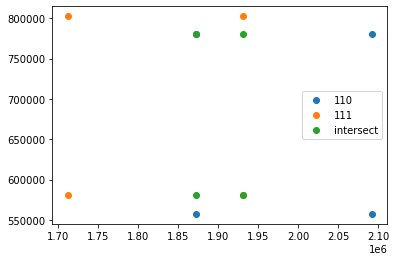

In [25]:
plt.scatter(y=[Lake_Mask_110.y.min(),Lake_Mask_110.y.max(), Lake_Mask_110.y.max(), Lake_Mask_110.y.min()],
           x = [Lake_Mask_110.x.min(),Lake_Mask_110.x.min(), Lake_Mask_110.x.max(),Lake_Mask_110.x.max()])
plt.scatter(y=[Lake_Mask_111.y.min(),Lake_Mask_111.y.max(), Lake_Mask_111.y.max(), Lake_Mask_111.y.min()],
           x = [Lake_Mask_111.x.min(),Lake_Mask_111.x.min(), Lake_Mask_111.x.max(),Lake_Mask_111.x.max()])
plt.scatter(y=[intersect_y.min(),intersect_y.max(), intersect_y.max(), intersect_y.min()],
           x = [intersect_x.min(),intersect_x.min(), intersect_x.max(),intersect_x.max()])
plt.legend(['110','111','intersect'])

In [26]:
y_merged = np.linspace((Lake_Mask_111.y.min()),
            (Lake_Mask_110.y.max()),
            int(int((Lake_Mask_111.y.max())-int(Lake_Mask_110.y.min()))/int(Lake_Mask_110.res[0])))

In [27]:
x_merged = np.linspace((Lake_Mask_111.x.min()),
            (Lake_Mask_110.x.max()),
            int(int((Lake_Mask_110.x.max())-int(Lake_Mask_111.x.min()))/int(Lake_Mask_110.res[0])))

In [28]:
lake_mask_merged = np.zeros([int(int((Lake_Mask_111.y.max())-int(Lake_Mask_110.y.min()))/int(Lake_Mask_110.res[0])),
                             int(int((Lake_Mask_110.x.max())-int(Lake_Mask_111.x.min()))/int(Lake_Mask_110.res[0]))])

In [29]:
lake_mask_merged[int(np.argwhere(Lake_Mask_111.y.values==intersect_y.max()))-2
                 :-1,
                 int(np.argwhere(Lake_Mask_111.x.values==intersect_x.min()))-2
                 :-1]=Lake_Mask_110.lake_mask

In [30]:
lake_mask_merged[0:Lake_Mask_111.sizes['y'],
                 0:Lake_Mask_111.sizes['x']]=Lake_Mask_111.lake_mask

In [32]:
lake_mask_merged = np.flipud(lake_mask_merged)

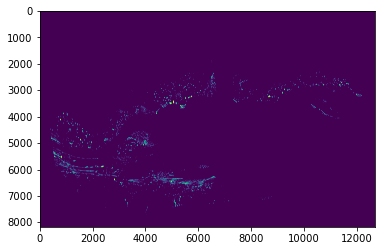

In [33]:
plt.imshow(lake_mask_merged)

In [34]:
Lake_Mask_merged = xr.Dataset(
    {
    "lake_mask":(
    ('y','x'),
    lake_mask_merged)
    }, coords = {'x': x_merged, 'y': y_merged},
    attrs   = Lake_Mask_110.attrs)

In [35]:
Lake_Mask_merged

<xarray.Dataset>
Dimensions:    (x: 12680, y: 8170)
Coordinates:
  * x          (x) float64 1.712e+06 1.712e+06 1.712e+06 ... 2.092e+06 2.092e+06
  * y          (y) float64 5.811e+05 5.811e+05 5.811e+05 ... 7.806e+05 7.806e+05
Data variables:
    lake_mask  (y, x) float64 0.0 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
Attributes:
    transform:      (30.0, 0.0, 1871685.0, 0.0, -30.0, 780615.0)
    crs:            +init=epsg:3031
    res:            (30.0, 30.0)
    is_tiled:       1
    nodatavals:     (nan,)
    scales:         (1.0,)
    offsets:        (0.0,)
    AREA_OR_POINT:  Point

In [36]:
Lake_Mask_merged.to_netcdf('REMAWaterRouting/Amery_mask.nc')